<a href="https://colab.research.google.com/github/esraonal/language_models/blob/main/bert_lstm_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Description

# Seperation or corporation of recurrence and self-attention

This study investigates different aspects of the human language processing system and how they are reflected in recent deep neural network architectures.  Numerous research supports that neural networks that utilize recurrence not only show promising results in many natural language processing tasks but also give insights into how sentence comprehension takes place in humans and what type of complex cognitive operations underlie this process such as incrementality. However, successive neural networks such as [Transformers](https://arxiv.org/pdf/1706.03762.pdf) that make use of a self-attention mechanism are now considered the state-of-the-art in language modeling due to their strength in drawing direct relations between words in sequential data without recurrence.  They separately attend to different aspects of the human language processing system, but why one performs better than the other one is not yet clear. Therefore, what constitutes the core of this study is an architecture that combines both mechanisms. We specifically use [BERT](https://aclanthology.org/N19-1423.pdf) (Bidirectional Encoder Representations from Transformers) and LSTM layers to create and compare different language models.

In this regard, we will train three different language models with self-attention (BERT) and recurrence (LSTM) using [**masking approach**](https://aclanthology.org/N19-1423.pdf) for training.
* BERT model
* LSTM model
* BERT + LSTM model

For the nature of our project, we won't be using pretrained word embeddings in our models so we will train these models from scratch using [**TensorFlow**](https://www.tensorflow.org/install) on the [**Amazon Polarity**](https://huggingface.co/datasets/Siki-77/amazon6_polarity) dataset loaded from Hugging Face Datasets.

## Masked Language Modeling (MLM) (Pretraining)
We will make use of masking approach for training which is called **Masked Language Modeling** (MLM).  Before feeding word sequences into our models, 15% of the words in each sequence are replaced with a **[mask]** token. The model then attempts to predict the original value of the masked words, based on the context provided by the other, non-masked, words in the sequence.

## NEXT: Next Sentence Prediction (NSP)! (Fine-tuning)
(In progress)

The NSP task forces the model to understand the relationship between two sentences. In this task, BERT is required to predict whether the second sentence is related to the first one. During training, the model is fed with 50% of connected sentences and another half with random sentence sequence.

# Set-up

We will train the models in [**TensorFlow**](https://www.tensorflow.org/install) with keras layers on Google Colab.  

* Let's import necessay libraries!

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

*  Set environment variables

In [ ]:
@dataclass
class Config:
    MAX_LEN = 128
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 7000
    EMBED_DIM = 64
    NUM_HEAD = 8  # used in bert model
    FF_DIM = 128  # used in bert model
    NUM_LAYERS = 1
    TRAIN_SIZE = 50000

config = Config()

# Dataset

Models are trained with 50,000 reviews (both negative and positive sentiment) from [**Amazon Polarity**](https://huggingface.co/datasets/Siki-77/amazon6_polarity) dataset from Hugging Face.


* Install following libraries in order to load the dataset from Hugging Face.

In [ ]:
! pip install datasets
! pip install apache_beam


* Import the libraries.  We will use ```load_dataset```

In [ ]:
import apache_beam
from datasets import load_dataset

* Load the dataset

In [ ]:
dataset = load_dataset("Siki-77/amazon6_polarity")
# print(dataset)

Dataset is split into training and test samples.  Additionally, the dataset has data fields such as label showing negative and positive rating scores, title, context containing the text and feeling encoding 0 as negative and 1 as positive.

See the data structure

```
DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'context', 'feeling'],
        num_rows: 249624
    })
    test: Dataset({
        features: ['label', 'title', 'context', 'feeling'],
        num_rows: 207317
    })
})
```

For training our language models, only context data which contains the body of the document is used, without the label/feeling or the title data. In total, there are 249,624 training samples and 207,317 test samples in this dataset as seen below.  We will only make use of the first 50,000 samples to train our models.

* Get training and test samples

In [ ]:
train_amazon_review = []
test_amazon_review = []

length_train = len(dataset['train'])
for i in range(length_train):
    train_amazon_review.append(dataset['train'][i]['context'])

length_test = len(dataset['test'])

test_amazon_review = []
for i in range(length_test):
    test_amazon_review.append(dataset['test'][i]['context'])

# train_size = 50000
train_amazon_review_subset = train_amazon_review[:config.TRAIN_SIZE]
print(dataset['test'][100]['context'])

One sample can be seen below.
```
'"Boutique" quality sailor suit. I liked it so much I even bought the coordinating dress for my daughter. You will not be disappointed with this find!'
```

# Data preprocessing

Since we need to feed numbers as vectors, not raw text to train our language models, we will vectorize the reviews. Also, when masked, the mask token replaces the token ID with 6999 as seen below.

Example:
```
Text sample: Definitely a good buy. I strongly recommend it!
Token IDs: [  271    7   40   99    4 2521 144    3  ] # this sequence is padded to the maxlen which is 128

Masked text sample: Definitely a good [mask]. I strongly recommend it!
Masked token IDs: [  271    7   40 6999    4 2521  144    3   ] # this sequence is padded to the maxlen which is 128
```

## Step 1: Create the vocabulary

We will use the [**TextVectorization**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) to index the vocabulary found in the dataset. Later, we'll use the same layer instance to vectorize the samples .

Our layer will only consider the top 7,000 words, and will truncate or pad sequences to be actually 128 tokens long.

```
vocab_size = 7000  # Only consider the top 7k words
maxlen = 128  # Only consider the first 128 words of each amazon review
```
We will also use a customized standardization for this dataset and add the masked token to the vocabulary.

```
[mask] token ID: 6999
```

In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}\"~"), ""
    )

vectorizer = layers.TextVectorization(
    max_tokens=config.VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=config.MAX_LEN,
    standardize=custom_standardization
    )

texts = train_amazon_review_subset
vectorizer.adapt(texts)

# Create the vocabulary
vocab = vectorizer.get_vocabulary()

# Add the [mask] token to the end of the vocabulary
vocab = vocab[: config.VOCAB_SIZE - 1] + ["[mask]"]
vectorizer.set_vocabulary(vocab)

mask_token_id = vectorizer(["[mask]"]).numpy()[0][0]
# print('[mask] token ID: ' + str(mask_token_id))

## Step 2: Vectorize the training data


In [ ]:
output = vectorizer(texts)
vectorized_train_review = output.numpy()

## Step 3: Mask 15% of the tokens




Since MLM is used to train our models, we will mask 15% of the tokens in our data. However, there is a problem with this masking approach since the model only tries to predict when the [mask] token is present in the input, while we want the model to try to predict the correct tokens regardless of what token is present in the input. To deal with this issue, out of the 15% of the tokens selected for masking:
- 80% of the tokens are actually replaced with the token [mask].
- 10% of the time tokens are replaced with a random token.
- 10% of the time tokens are left unchanged.

Masked data is used as the input while unmasked data as the labels.

In [ ]:
def get_masked_input_and_labels(vectorized_data):

    # 15% masking
    inp_mask = np.random.rand(*vectorized_data.shape) < 0.15
    inp_mask[vectorized_data <= 2] = False

    # Prepare input
    vectorized_data_masked = np.copy(vectorized_data)

    # Set input to [MASK] which is the last token for the 90% of tokens
    # This means leaving 10% unchanged
    inp_mask_mask = inp_mask & (np.random.rand(*vectorized_data.shape) < 0.90)
    vectorized_data_masked[
        inp_mask_mask
    ] = mask_token_id  # mask token is the last in the dict

    # Set 10% to a random token
    inp_mask_random = inp_mask_mask & (np.random.rand(*vectorized_data.shape) < 1 / 9)
    vectorized_data_masked[inp_mask_random] = np.random.randint(
        3, mask_token_id, inp_mask_random.sum()
    )
    # vectorized_data_labels would be same as encoded_texts i.e input tokens
    vectorized_data_labels = np.copy(vectorized_data)

    print('Input (masked): ')
    print(vectorized_data_masked)
    print('Labels (unmasked): ')
    print(vectorized_data_labels)
    return vectorized_data_masked, vectorized_data_labels

# Prepare data for masked language model
masked_train, masked_labels = get_masked_input_and_labels(
    vectorized_train_review
)

mlm_data = tf.data.Dataset.from_tensor_slices(
    (masked_train, masked_labels)
)

# batch_size = 16
mlm_data = mlm_data.shuffle(1000).batch(config.BATCH_SIZE)

# Masked Language Models


## Model 1: BERT
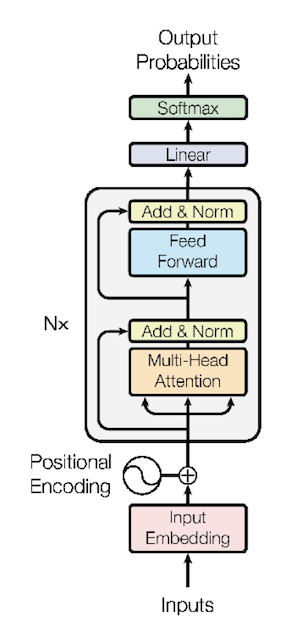


### Create positional encoding matrix


In [ ]:
def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

### Create self-attention module


In [ ]:
def self_attention_layer(query, key, value, i):

    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="Multi_head_attention",
    )(query, key, value)
    attention_output = layers.Dropout(0.1)(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1)(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6
    )(attention_output + ffn_output)

    return sequence_output

### BERT


In [ ]:
def bert_encoder():

    # Input layer
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)

    # Embedding layer
    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)

    # Positional encoding
    position_embeddings = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings

    # Self-attention layer
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = self_attention_layer(encoder_output, encoder_output, encoder_output, i)

    # Soft-max layer
    mlm_output = layers.Dense(config.VOCAB_SIZE, activation="softmax")(
        encoder_output
    )

    # Create the model
    bert_model = tf.keras.Model(inputs=inputs, outputs=mlm_output, name="masked_bert")

    # Set optimizer as Adam, loss as Sparse Categorical Crossentropy
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    bert_model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy())

    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()]

    return bert_model

# Initiate the model
bert_mlm = bert_encoder()
# See the model architecture
bert_mlm.summary()

## Model 2: LSTM


In [ ]:
def lstm():

    # Input layer
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)

    # Embedding layer
    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding", mask_zero=True
    )(inputs)

    # Two LSTM layers followed by Dropout layers
    lstm_output = layers.LSTM(config.EMBED_DIM, return_sequences=True)(word_embeddings)
    lstm_output = layers.Dropout(0.1)(lstm_output)
    lstm_output = layers.LSTM(config.EMBED_DIM, return_sequences=True)(lstm_output)
    lstm_output = layers.Dropout(0.1)(lstm_output)

    # Softmax layer
    lstm_output = layers.Dense(config.VOCAB_SIZE, activation="softmax")(
        lstm_output
    )

    # Create the LSTM model
    lstm_model = tf.keras.Model(inputs, lstm_output, name="masked_lstm")

    # Set Adam as optimizer
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)

    # Cross entropy as loss
    lstm_model.compile(optimizer=optimizer,  loss=keras.losses.SparseCategoricalCrossentropy(),

    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()])

    return lstm_model

# Initiate the model
lstm_mlm = lstm()
# See the model architecture
lstm_mlm.summary()

## Model 3: BERT + LSTM

We will combine the self-attention module with two LSTM layers.

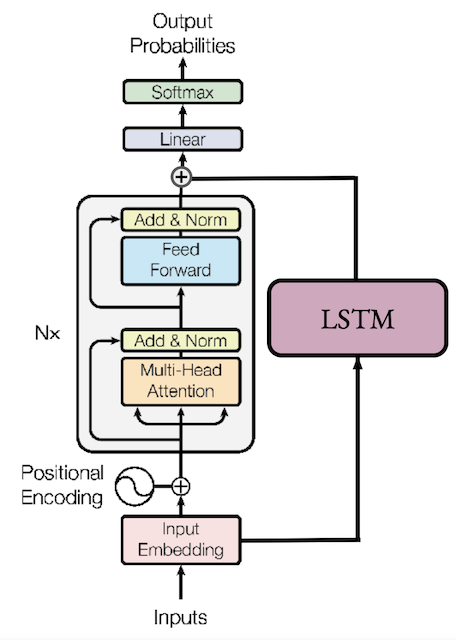



In [ ]:
def bert_lstm():

    # Input layer
    inputs = layers.Input((config.MAX_LEN,), dtype=tf.int64)

    # Embedding layer
    word_embeddings = layers.Embedding(
        config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding"
    )(inputs)

    # Positional encodings
    position_embeddings = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings

    # Self-attention layer
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = self_attention_layer(encoder_output, encoder_output, encoder_output, i)

    # LSTM layers taking word embeddings directly
    lstm_output = layers.LSTM(config.EMBED_DIM, return_sequences=True)(word_embeddings)
    lstm_output = layers.Dropout(0.1)(lstm_output)
    lstm_output = layers.LSTM(config.EMBED_DIM, return_sequences=True)(lstm_output)
    lstm_output = layers.Dropout(0.1)(lstm_output)

    # Encoder output and LSTM output are added together
    lstm_attention = encoder_output + lstm_output

    # Softmax layer
    mlm_output = layers.Dense(config.VOCAB_SIZE, activation="softmax")(
        lstm_attention
    )

    # Create the BERT + LSTM model
    mlm_model = tf.keras.Model(inputs=inputs, outputs=mlm_output, name="masked_bert_lstm")

    # Adam as optimizer
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)

    # Cross entropy loss
    mlm_model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.SparseCategoricalCrossentropy())

    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()]

    return mlm_model

# Initiate the model
bert_lstm_mlm = bert_lstm()
# See the model architecture
bert_lstm_mlm.summary()

# Training

## Callbacks

Before we train, we will create [callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) to see the progress of the model with each epoch.

In [ ]:
id2token = dict(enumerate(vectorizer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}

class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens)

        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            input = np.copy(self.sample_tokens[0])
            tokens = np.copy(self.sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(input),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)

sample_tokens = vectorizer(["Definitely a good buy. I strongly [mask] it"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())
sample_tokens2 = vectorizer(["Definitely a [mask] buy. I strongly recommend it"])
generator_callback2 = MaskedTextGenerator(sample_tokens2.numpy())
sample_tokens3 = vectorizer(["Definitely a good [mask]. I strongly recommend it"])
generator_callback3 = MaskedTextGenerator(sample_tokens3.numpy())

## Train

In [ ]:
epoch = 5

bert_mlm.fit(mlm_data, epochs=epoch, callbacks=[generator_callback, generator_callback2, generator_callback3])
bert_mlm.save("masked_bert.h5")

lstm_mlm.fit(mlm_data, epochs=epoch, callbacks=[generator_callback, generator_callback2, generator_callback3])
lstm_mlm.save("masked_lstm.h5")

bert_lstm_mlm.fit(mlm_data, epochs=epoch, callbacks=[generator_callback, generator_callback2, generator_callback3])
bert_lstm_mlm.save("masked_bert_lstm.h5")

# Evaluation



## Predict next word

In [ ]:
def decode(tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

def convert_ids_to_tokens(id):
        return id2token[id]

def generate_next_word(text, max_length, model):

    for i in range(max_length):
        predict = []
        predict.append(text + " [mask]")
        sample_tokens = vectorizer(predict)
        prediction = model.predict(sample_tokens.numpy())

        masked_index = np.where(sample_tokens == mask_token_id)
        masked_index = masked_index[1]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-1 :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": decode(sample_tokens[0].numpy()),
                "prediction": decode(tokens),
                "probability": v,
                "predicted mask token": convert_ids_to_tokens(p),
            }
            pprint(result)

        next_word = convert_ids_to_tokens(top_indices[0])
        text = text + " " + next_word


text = "I would "

In [ ]:
generate_next_word(text, 5, bert_mlm)
generate_next_word(text, 5, lstm_mlm)
generate_next_word(text, 5, bert_lstm_mlm)

One of the predictions for this sample from the test set is given below.

```
Input: I would
Predition:  I would recommend this book it again
```

## Predict masked token

In [ ]:
def decode(tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

def convert_ids_to_tokens(id):
        return id2token[id]

def predict_masked(text, model):

    sample_tokens = vectorizer(text)
    prediction = model.predict(sample_tokens.numpy())

    masked_index = np.where(sample_tokens == mask_token_id)
    masked_index = masked_index[1]
    mask_prediction = prediction[0][masked_index]

    top_indices = mask_prediction[0].argsort()[-1 :][::-1]
    values = mask_prediction[0][top_indices]

    for i in range(len(top_indices)):
        p = top_indices[i]
        v = values[i]
        tokens = np.copy(sample_tokens[0])
        tokens[masked_index[0]] = p
        result = {
            "input_text": decode(sample_tokens[0].numpy()),
            "prediction": decode(tokens),
            "probability": v,
            "predicted mask token": convert_ids_to_tokens(p),
        }
        pprint(result)

text2 = ["Definitely a good [mask]. I strongly recommend it"]

In [ ]:
predict_masked(text2, bert_mlm)
predict_masked(text2, lstm_mlm)
predict_masked(text2, bert_lstm_mlm)

One of the predictions for this sample from the test set is given below.

```
Input: Definitely a good [mask]. I strongly recommend it!
(Expected) Output: Definitely a good buy. I strongly recommend it!
(Predicted) Output: Definitely a good product. I strongly recommend it!
```